# Illustrating the consequences of transformer fine-tuning for text classification

This notebook illustrates how fine-tuning a transformer encoder model for text classifciation affects its embedding behavior.

We take a pre-trained (multilingual) classifier developed by PolTextLab lead by Miklos Sebök: https://capbabel.poltextlab.com/ 

### Setup

In [1]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    !pip install -q transformers==4.44.1 matplotlib==3.9.2 umap-learn==0.5.6

if COLAB:
    data_path = 'https://raw.githubusercontent.com/haukelicht/advanced_text_analysis/refs/heads/main/data/labeled/parlee/'
else:
    import os
    data_path = os.path.join('..', 'data', 'labeled', 'parlee', '')

In [2]:
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import umap

import matplotlib.pyplot as plt

from typing import List

from tqdm.auto import tqdm

In [3]:
SOURCE_MODEL_NAME = 'xlm-roberta-large'
FINETUNED_MODEL_NAME = 'poltextlab/xlm-roberta-large-english-parlspeech-cap-v3'

## Load the data

In [4]:
label_map = pd.read_csv(data_path+'cap_topic_codes.tsv', sep='\t')
id2label = {row.code: row.topic for row in label_map.itertuples()}
label2id = {v: k for k, v in id2label.items()}

In [5]:
df = pd.read_csv(data_path+'UK_2009_2014_annotated_sample.csv', encoding = "ISO-8859-1")

df['label'] = df.CAP.map(id2label)
df = df[['text', 'label']]
df = df[~df.text.isna()]

top10_topics = df['label'].value_counts()[:10].keys().tolist()
examples = df[df.label.isin(top10_topics)]
examples = examples.groupby('label').sample(16*4, random_state=42)

In [6]:
examples.groupby('label').sample(1, random_state=42)

,text,label
1939,"I beg to move, That leave be given to bring in...","Banking, Finance and Domestic Commerce"
4844,We do need that experience to continue at the ...,Defence
2904,We must address that now.,Government Operations
2623,Does this represent more than some isolated in...,Health
3163,"Yes, 135 countries have recognised Palestine a...",International Affairs and Foreign Aid
1490,When the traditional industries were still ope...,Labour and Employment
5189,"Notwithstanding what the Minister has said, 40...","Law, Crime and Family Issues"
2636,The principal question for me is whether the s...,Macroeconomics
3903,The review also determined that relative fundi...,"Public Lands, Water Management, Colonial and T..."
4800,Every plane flying from Britain to north Ameri...,Transportation


## Inspect the transformer embeddings

In [7]:
# helper function to get the transformer embeddings of a list of texts
def get_last_hidden_state(texts: List[str], tokenizer, model, batch_size: int=16): 

    embeddings = []    
    for i in tqdm(range(0, len(texts), batch_size)):
        # tokenize texts
        batch_inputs = tokenizer(texts[i:i+batch_size], padding='max_length', truncation=True, return_tensors="pt")          
        # get the final hidden layer embeddings
        with torch.no_grad():
            batch_outputs = model(**batch_inputs.to(model.device), output_hidden_states=True)
            # selects all rows (:) and the first column (0) of the last_hidden_state tensor, which corresponds to the representation of the [CLS] that is typically used for classification tasks.
            batch_embeddings = batch_outputs.hidden_states[-1][:, 0].cpu().numpy()
        embeddings.append(batch_embeddings)
            
    embeddings = np.concatenate(embeddings, axis=0)  
    return embeddings

### before fine-tuning

In [8]:
# load the source model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL_NAME, num_labels=len(label2id), label2id=label2id).to(device)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# get the transformer embeddings
embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


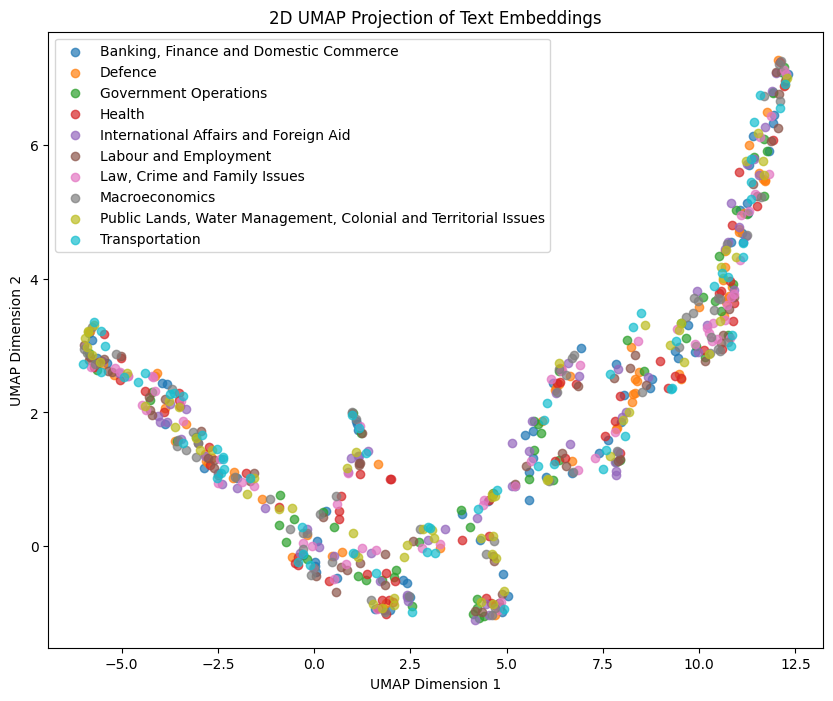

In [13]:

# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(10, 8))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, alpha=0.7)
plt.legend()
plt.title('2D UMAP Projection of Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

There is no clear separating between examples of the different label classes.

### How to fine-tune

In [27]:
# let's look at the components of the classification head
model.classifier

XLMRobertaClassificationHead(
  (dense): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=1024, out_features=21, bias=True)
)

The model with the classification head generates logits for text inputs:


In [28]:
# get the logits for the first text
text = examples.text.values[0]
inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

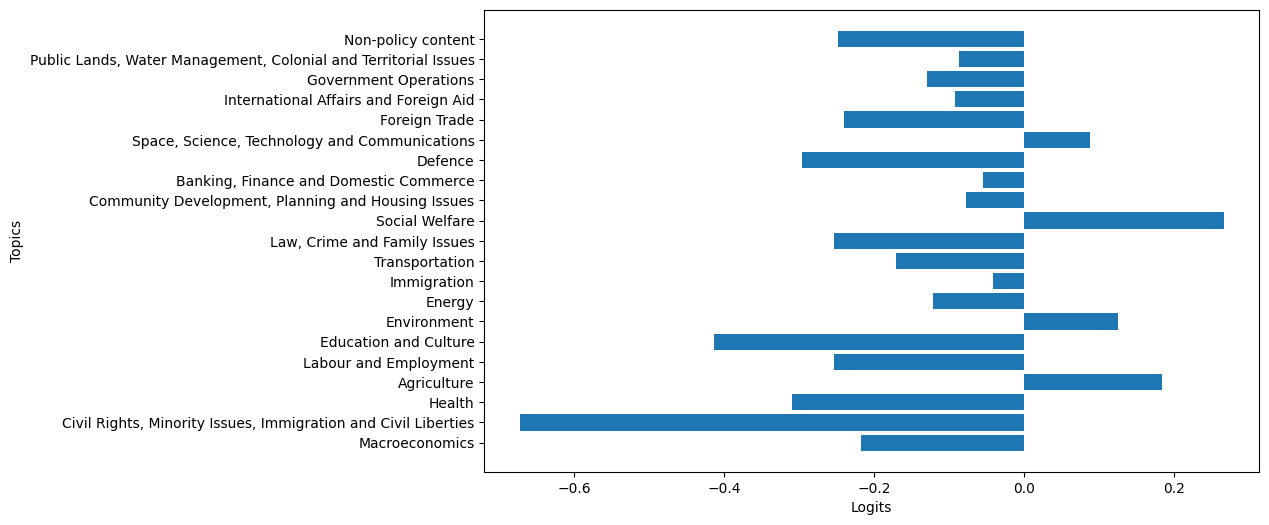

In [30]:
# plot the logits as bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(id2label.values()), logits)
plt.xlabel('Logits')
plt.ylabel('Topics')
plt.show()

We can convert the logits to pseudo-probabilities using the softmax function:

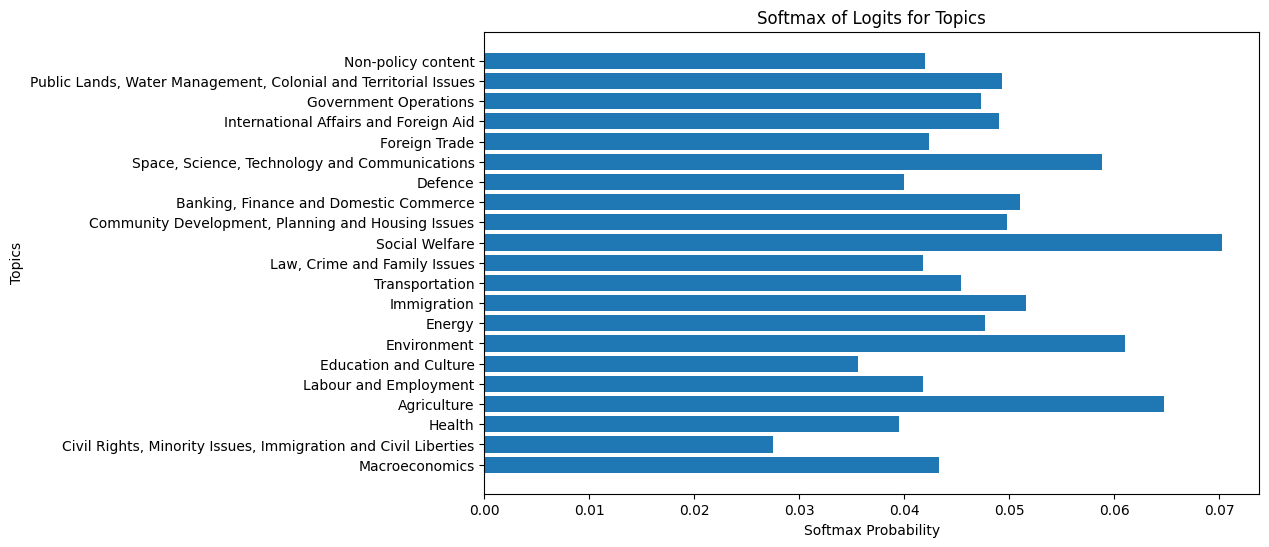

In [31]:
import torch.nn.functional as F

# Apply softmax to logits
softmax_logits = F.softmax(torch.tensor(logits), dim=0).numpy()

# Plot the softmax logits as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(id2label.values()), softmax_logits)
plt.xlabel('Softmax Probability')
plt.ylabel('Topics')
plt.title('Softmax of Logits for Topics')
plt.show()

In [32]:
# the "true" (observed) label is
examples.label.values[0]

'Banking, Finance and Domestic Commerce'

**Optimization goal:** We want to make the softmax probability of class "'Banking, Finance and Domestic Commerce'" as high as possible

### after fine-tuning

In [14]:
# load the source model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_NAME).to(device)

In [15]:
# get the transformer embeddings
finetuned_embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


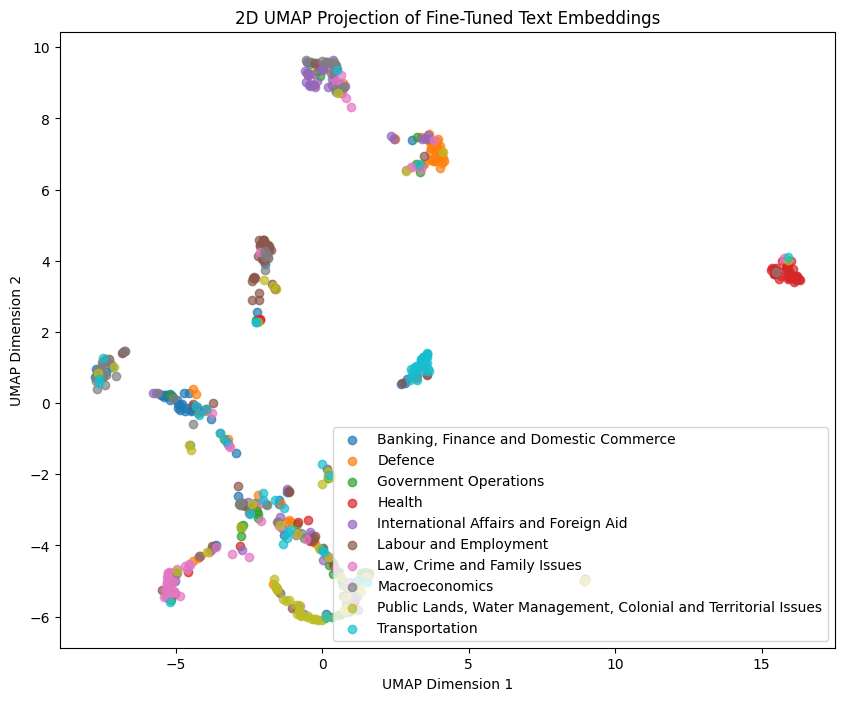

In [16]:

# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42)
finetuned_embeddings_2d = reducer.fit_transform(finetuned_embeddings)

# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(10, 8))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(finetuned_embeddings_2d[indices, 0], finetuned_embeddings_2d[indices, 1], label=label, alpha=0.7)
plt.legend()
plt.title('2D UMAP Projection of Fine-Tuned Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

Let's look at the logits predicted by this model

In [17]:
# get the logits for the first text
text = examples.text.values[0]
inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

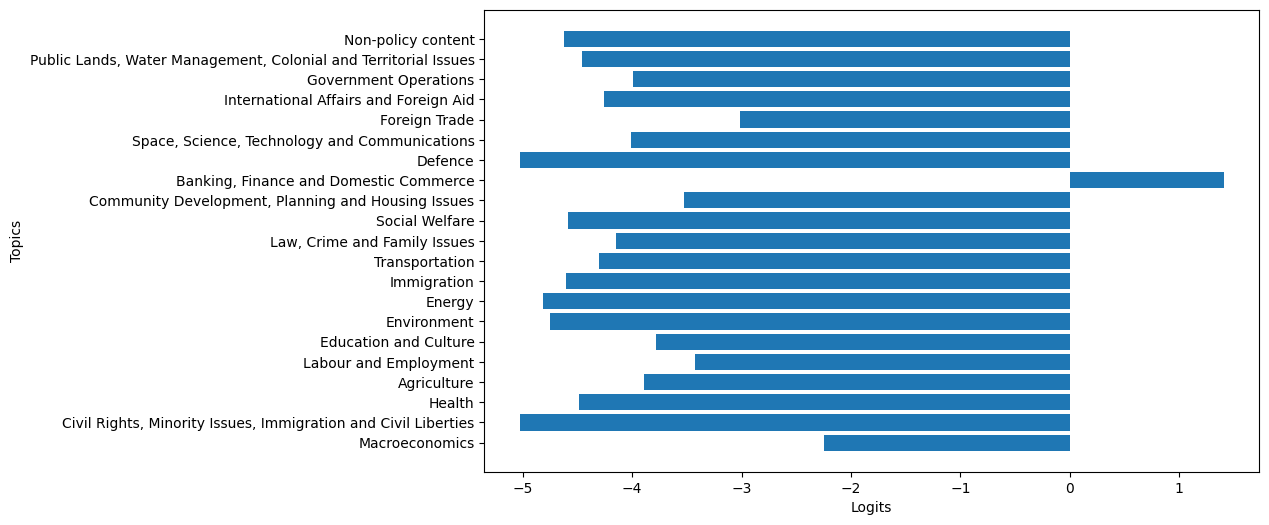

In [37]:
# plot the logits as bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(id2label.values()), logits)
plt.xlabel('Logits')
plt.ylabel('Topics')
plt.show()

We can convert the logits to pseudo-probabilities using the softmax function:

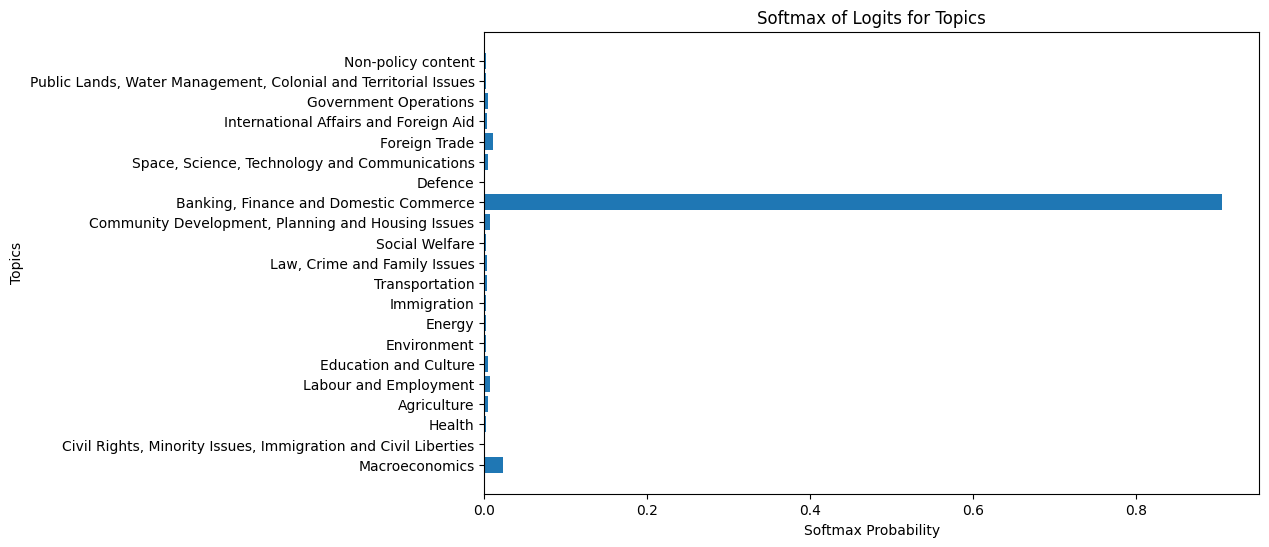

In [38]:
import torch.nn.functional as F

# Apply softmax to logits
softmax_logits = F.softmax(torch.tensor(logits), dim=0).numpy()

# Plot the softmax logits as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(id2label.values()), softmax_logits)
plt.xlabel('Softmax Probability')
plt.ylabel('Topics')
plt.title('Softmax of Logits for Topics')
plt.show()

#### The fine-tuned model gives better cluster assignments

In [18]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score for embeddings
labels = examples['label'].astype('category').cat.codes
silhouette_score_embeddings = silhouette_score(embeddings, labels)
print(f'Silhouette Score for embeddings: {silhouette_score_embeddings}')

# Compute Silhouette Score for finetuned_embeddings
silhouette_score_finetuned_embeddings = silhouette_score(finetuned_embeddings, labels)
print(f'Silhouette Score for finetuned embeddings: {silhouette_score_finetuned_embeddings}')

Silhouette Score for embeddings: -0.0906398743391037
Silhouette Score for finetuned embeddings: 0.04102429747581482


In [19]:
from sklearn.metrics import pairwise_distances

def compute_coherence(embeddings, labels):
    label_categories = labels.unique()
    coherence_scores = {}
    
    for label in label_categories:
        label_indices = labels == label
        label_embeddings = embeddings[label_indices]
        
        # Compute pairwise distances within the label category
        distances = pairwise_distances(label_embeddings)
        
        # Compute coherence as the mean of the pairwise distances
        coherence = np.mean(distances)
        coherence_scores[label] = coherence
    
    return coherence_scores

# Compute coherence for embeddings
coherence_embeddings = compute_coherence(embeddings, examples['label'])
coherence_finetuned_embeddings = compute_coherence(finetuned_embeddings, examples['label'])

pd.DataFrame(coherence_embeddings.values(), index=coherence_embeddings.keys(), columns=['embeddings']).join(
    pd.DataFrame(coherence_finetuned_embeddings.values(), index=coherence_finetuned_embeddings.keys(), columns=['finetuned_embeddings'])
)

,embeddings,finetuned_embeddings
"Banking, Finance and Domestic Commerce",2.599052,30.442879
Defence,2.561882,25.815056
Government Operations,2.463579,28.387806
Health,2.600798,24.316710
International Affairs and Foreign Aid,2.494964,26.166527
Labour and Employment,2.979535,30.202045
"Law, Crime and Family Issues",2.767194,27.489399
Macroeconomics,2.840464,31.366787
"Public Lands, Water Management, Colonial and Territorial Issues",2.908066,28.136639
Transportation,2.919645,28.241816


#### How much do the embeddings change from the pre-trained checkpoint?

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


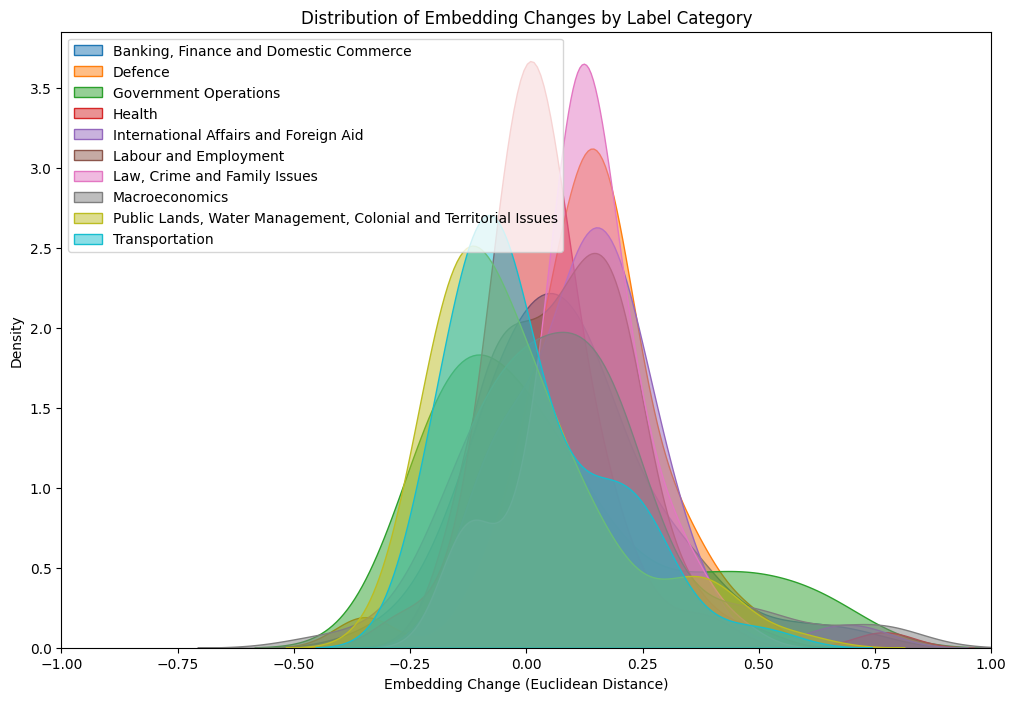

In [22]:
# import cosine_similarity from sklearn
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

# Compute the change in embeddings as cosine similarity
embedding_changes = [cosine_similarity(embeddings[i].reshape(1, -1), finetuned_embeddings[i].reshape(1, -1))[0][0] for i in range(len(examples))]

# Add the changes to the examples dataframe
examples['embedding_change'] = embedding_changes

# Plot the distribution of embedding changes in a density plot by label category
plt.figure(figsize=(12, 8))
for label in examples['label'].unique():
    subset = examples[examples['label'] == label]
    sns.kdeplot(subset['embedding_change'], label=label, fill=True, alpha=0.5)

# set the x-axis limits to -1 and 1
plt.xlim(-1, 1)
plt.legend()
plt.title('Distribution of Embedding Changes by Label Category')
plt.xlabel('Embedding Change (Euclidean Distance)')
plt.ylabel('Density')
plt.show()

In [63]:
examples['embedding_change_abs'] = examples.embedding_change.abs()
examples.groupby('label').apply(lambda x: x.sort_values('embedding_change_abs', ascending=False).head(5)).reset_index(drop=True)

,text,label,embedding_change,embedding_change_abs
0,Gone!,"Banking, Finance and Domestic Commerce",0.712770,0.712770
1,The overwhelming impression is that far too ma...,"Banking, Finance and Domestic Commerce",0.606925,0.606925
2,I could not agree more with you about the impo...,"Banking, Finance and Domestic Commerce",0.512045,0.512045
3,They operate in ways that undermine that profe...,"Banking, Finance and Domestic Commerce",0.414763,0.414763
4,We have heard about a number of issues relatin...,"Banking, Finance and Domestic Commerce",0.374507,0.374507
5,Our armed forces are being cut.,Defence,0.495184,0.495184
6,"Indeed, it is not just on the high seas that t...",Defence,0.462131,0.462131
7,Friend the Minister for Europe has done in ope...,Defence,0.377305,0.377305
8,"Otherwise, I fear that we will have to come ba...",Defence,0.356390,0.356390
9,"Otherwise, I fear that we will have to come ba...",Defence,0.356390,0.356390
